<a href="https://colab.research.google.com/github/Khajavi8056/Hip/blob/main/01_Trailing_Multiple_Assets_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1 - Import test data

In [7]:
!pip install pandas-ta  backtesting


In [8]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import os
tqdm.pandas()

def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path)
    df["Gmt time"] = df["Gmt time"].str.replace(".000", "")
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S')
    df = df[df.High != df.Low]
    df.set_index("Gmt time", inplace=True)
    return df

def read_data_folder(folder_path="./data"):
    dataframes = []
    file_names = []
    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = read_csv_to_dataframe(file_path)
            dataframes.append(df)
            file_names.append(file_name)
    return dataframes, file_names

def apply_technical_indicators(df):
    df["EMA_slow"] = ta.ema(df.Close, length=200)
    df["EMA_fast"] = ta.ema(df.Close, length=100)
    df['RSI'] = ta.rsi(df.Close, length=14)
    my_bbands = ta.bbands(df.Close, length=20, std=2.0)
    df['ATR'] = ta.atr(df.High, df.Low, df.Close, length=10)
    df = df.join(my_bbands)
    return df

def ema_signal(df, current_candle, backcandles):
    df_slice = df.reset_index().copy()
    # Get the range of candles to consider
    start = max(0, current_candle - backcandles)
    end = current_candle
    relevant_rows = df_slice.iloc[start:end]

    # Check if all EMA_fast values are below EMA_slow values
    if all(relevant_rows["EMA_fast"] < relevant_rows["EMA_slow"]):
        return 1
    elif all(relevant_rows["EMA_fast"] > relevant_rows["EMA_slow"]):
        return 2
    else:
        return 0

def update_dataframe_ema_signal(df):
    df.reset_index(inplace=True)
    df['EMASignal'] = df.progress_apply(lambda row: ema_signal(df, row.name, 7) if row.name >= 20 else 0, axis=1)
    return df

def total_signal(df, current_candle, backcandles):
    c_BB_width =  (abs(df['BBL_20_2.0'][current_candle] - df['BBU_20_2.0'][current_candle]) / df['BBL_20_2.0'][current_candle]) > 0.0015
    if (ema_signal(df, current_candle, backcandles)==2
        and df.Close[current_candle]<=df['BBL_20_2.0'][current_candle]
        and c_BB_width
        and all(df.iloc[current_candle-backcandles:current_candle]["RSI"] >= 30)
        ):
            return 2
    if (ema_signal(df, current_candle, backcandles)==1
        and df.Close[current_candle]>=df['BBU_20_2.0'][current_candle]
        and c_BB_width
        and all(df.iloc[current_candle-backcandles:current_candle]["RSI"] <= 70)
        ):

            return 1
    return 0

def add_total_signal(df):
    df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name, 7), axis=1)
    return df

def candles_trend_signal(df, current_candle, backcandles):
    """
    This function calculates the total signal based on the following criteria:
    - If the previous 'backcandles' candles are all above the corresponding EMA values, it returns 2 (bullish).
    - If the previous 'backcandles' candles are all below the corresponding EMA values, it returns 1 (bearish).
    - Otherwise, it returns 0 (neutral).

    Parameters:
    df (DataFrame): DataFrame containing the stock data with 'High', 'Low', and 'EMA_fast' columns.
    current_candle (int): The index of the current candle.
    backcandles (int): The number of previous candles to check.

    Returns:
    int: Signal value (2 for bullish, 1 for bearish, 0 for neutral).
    """
    bullish = True
    bearish = True

    for i in range(current_candle - backcandles, current_candle+1):
        if i < 0:
            return 0  # Not enough data to evaluate

        if df.High[i] <= df['EMA_fast'][i] or df.Low[i] <= df['EMA_fast'][i]:
            bullish = False

        if df.High[i] >= df['EMA_fast'][i] or df.Low[i] >= df['EMA_fast'][i]:
            bearish = False

    if bullish:
        return 2
    if bearish:
        return 1
    return 0

def update_total_signal(df, backcandles=5):
    # Calculate signal for all candles
    df['candle_trend_signal'] = [candles_trend_signal(df, x, backcandles=backcandles) if x >= backcandles else 0 for x in tqdm(df.index)]
    df['TotalSignal'] = df.apply(lambda row: row['TotalSignal'] if row['TotalSignal'] == row['candle_trend_signal'] else 0, axis=1)
    return df

In [9]:
ldf, names = read_data_folder()

100%|██████████| 7/7 [00:00<00:00, 50.55it/s]


In [10]:
names

['AUDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDCHF_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDJPY_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'EURUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'NZDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'GBPUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'XAUUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv']

In [11]:
folder_path = "./data"
dataframes, file_names = read_data_folder(folder_path)

for i, df in enumerate(dataframes):
    print("working on dataframe ", i, "...")
    df = apply_technical_indicators(df)
    df = update_dataframe_ema_signal(df)
    df = add_total_signal(df)
    df = update_total_signal(df)
    dataframes[i] = df  # Update the dataframe in the list


100%|██████████| 7/7 [00:00<00:00, 49.63it/s]


working on dataframe  0 ...


100%|██████████| 2197/2197 [00:01<00:00, 1499.12it/s]


working on dataframe  1 ...


100%|██████████| 2197/2197 [00:00<00:00, 4410.39it/s]


working on dataframe  2 ...


100%|██████████| 2197/2197 [00:00<00:00, 4546.70it/s]


working on dataframe  3 ...


100%|██████████| 2197/2197 [00:00<00:00, 4421.51it/s]


working on dataframe  4 ...


100%|██████████| 2195/2195 [00:00<00:00, 2770.91it/s]


working on dataframe  5 ...


100%|██████████| 2196/2196 [00:00<00:00, 4536.77it/s]


working on dataframe  6 ...


100%|██████████| 2184/2184 [00:00<00:00, 4486.44it/s]


In [12]:
sum([frame["TotalSignal"].value_counts() for frame in dataframes], start=0)


,count
TotalSignal,
0,15236
1,64
2,63


In [13]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return df.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1
    slcoef = 1

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]

        for trade in self.trades:
            if trade.is_long:
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - slatr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + slatr)

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            self.buy(sl=sl1, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            self.sell(sl=sl1, size=self.mysize)

/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:53: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [14]:
results = []

for df in dataframes:
    bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(8, 31)],
                        maximize='Return [%]', max_tries=3000,
                            random_state=0,
                            return_heatmap=True)
    results.append(stats)

<ipython-input-14-1796143a0715>:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)


Backtest.optimize:   0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-14-1796143a0715>:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)


Backtest.optimize:   0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-14-1796143a0715>:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)


Backtest.optimize:   0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-14-1796143a0715>:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)


Backtest.optimize:   0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-14-1796143a0715>:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)


Backtest.optimize:   0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-14-1796143a0715>:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)


Backtest.optimize:   0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-14-1796143a0715>:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyStrat, cash=2500, margin=1/10, commission=0.0002)


Backtest.optimize:   0%|          | 0/23 [00:00<?, ?it/s]

In [15]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
max_trade_duration = max([r["Max. Trade Duration"] for r in results])
avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
print(f"Maximum Trade Duration: {max_trade_duration} days")
print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 41.60%
Number of Trades: 80.0
Maximum Drawdown: -7.61%
Average Drawdown: -1.60%
Win Rate: 43.44%
Best Trade: 17.56%
Worst Trade: -3.30%
Average Trade: 0.58%
Maximum Trade Duration: 87.0 days
Average Trade Duration: 21.78 days


In [16]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

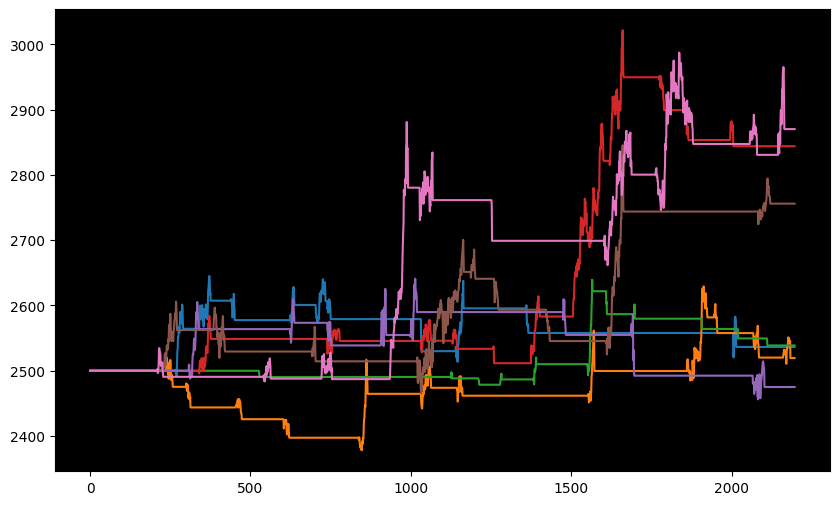

In [17]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=False).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')

In [18]:
[r["Return [%]"] for r in results]

[1.4595471727021505,
 0.7763500494877371,
 1.551478235184404,
 13.761110972572425,
 -0.9971421555858069,
 10.241126712862352,
 14.80992204599137]

In [19]:
names

['AUDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDCHF_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'USDJPY_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'EURUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'NZDUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'GBPUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv',
 'XAUUSD_Candlestick_1_D_BID_06.06.2017-15.06.2024.csv']